In [20]:
# This code was adapted from Mueller, J. et al. Cell 2017.Load Adaptation of Lamellipodial Actin Networks and further modified by Brent Ifemembi (bifemem1@jhu.edu)  

# ------------------ importing simulation library ---------------------- #
from actinNetwork import *
from numpy import arccos,sqrt,median,convolve,diagonal,corrcoef,argmax,insert,cumsum,std,unique,savetxt,vstack,nanstd,nanmean,hstack,NaN,zeros,correlate,ones
from numpy.random import normal,choice
from numpy.linalg import norm as normalg
from scipy.special import erf
from scipy.stats import zscore
from matplotlib.pyplot import *
from matplotlib.cm import *
from correlationAnalysis import *
import csv

# display plots in notebook
%matplotlib inline

# ------------------------------- parameters for simulation ----------------------------- #

# initial number of filaments N, and monomer size dN, and range in nm
N = 200; dN = 2.7; filRange = 1000.0;

# running time T, precision dt, and frame rate ds
T = 10; dt = 0.001; ds = 2.0; 

# velocity and width of polymerisation profile 
dw = 10*dN
visc = 8e-10 #8e-10 #8e-9 #0.8cP -> 8e-10 # 8 cP-> 8e-9 #1000 cP -> 1e-6 
constant = 1e5
Fo = 0.3; # Force Density 
# ------------------------------- velocity pertubation ---------------------------------- #

# time and duration of perturbation
tau = 6; dtau = T-tau

# velocity change during perturbation
dF = 0.0

sigma = 0.5 
noise = array([normal(scale=0.001) for t in arange(0,T,dt) ])
gaussian = array([ exp(-(t/sigma)**2)/sqrt(2*pi*sigma**2) for t in arange(-5.,5.,dt)])
noise = convolve(noise,gaussian,mode="same")

# velocity perturbation as heaviside function centered at tau
def F(v,t) :
    if t > tau and t < (tau + dtau):
        ff = Fo + constant*visc*(v[int(t/dt)]-1) #Change to t-1 # Difference in force between time points
        return ff
    else:
        return Fo

    #return Fo - heavisideTheta(t-tau)*dF

# sigmoid function
def sigmoid(x,beta) :
    
    return 1.0 / ( 1.0 + exp(-beta*x) )

# ------------------------------- rate assumptions ---------------------------------- #

# define polymerisation rate in terms of
# critical angle given unperturbed velocity

# rates for travelling heavisides
#lambdaRate = vo/(dN*cos(phiCrit))

lambdaRate = 141.0
betaRate = 1.0
kappaRate = 1.0

# defining rate functions
def rLambda(x,y,t) :
    return lambdaRate*heavisidePi(y,dw)
   
def rBeta(x,y,t) :
    return betaRate*heavisideTheta(y+dw/2)

def rKappa(x,y,t) :
    return 1000.0*heavisideTheta(-y-dw/2) + kappaRate*heavisidePi(y,dw)

In [ ]:
#plot(arange(0,T,dt),[ F(v,t) for t in arange(0,T,dt) ])
#plot(arange(0,T,dt),[ Fo-dF*sigmoid(t-tau,10) for t in arange(0,T,dt) ])
#ylim(0,0.4)

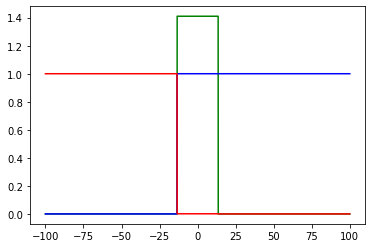

In [2]:
plot(arange(-100,100,0.01),[rLambda(0,y,0)/100. for y in arange(-100,100,0.01)],'g')
plot(arange(-100,100,0.01),[rBeta(0,y,0) for y in arange(-100,100,0.01)],'b')
plot(arange(-100,100,0.01),[rKappa(0,y,0)/1000 for y in arange(-100,100,0.01)],'r')

In [3]:
# binning cross x direction
xEdges = linspace(0,2000,27)
xCenters = (xEdges[:-1] + xEdges[1:]) / 2.0

xBinsize = xEdges[1]-xEdges[0]

# binning across phi direction
phiEdges1 = array([0,20,50,90])*pi/180
phiCenters1 = ( phiEdges1[1:]+phiEdges1[:-1] ) / 2.0

phiEdges2 = linspace(-pi/2,pi/2,10)
phiCenters2 = ( phiEdges2[1:]+phiEdges2[:-1] ) / 2.0

# function that calculates relevant statistics given a network object that has already been run
def getStatistics(networkObject,xEdges,phiEdges1,phiEdges2) :
    
    
    # getting positions
    xFil = networkObject.getPositions( networkObject.Monomers )
    xBranch = networkObject.getPositions( networkObject.Branches )
    xCap = networkObject.getPositions( networkObject.Caps )
    # This creates our spatial bins
    filMasks = [ ( x <= xFil.T[1] ) * ( xFil.T[1] <= y ) for x,y in zip(xEdges[:-1],xEdges[1:]) ]

    
    # angular orientation of filaments
    phiFil = networkObject.getAngles ( networkObject.Monomers )
    phiBranch = networkObject.getAngles ( networkObject.Branches )
    phiCap = networkObject.getAngles ( networkObject.Caps )
    # This gives us the number of filaments in each bin, which we find by asking for unique angles
    filNumber = array([ len(unique(phiFil[mask])) for mask in filMasks ]).astype(float)
    phiDensity = array([ histogram( phiFil[mask], bins=phiEdges2)[0] for mask in filMasks ])
    
    
    # calculating filament density in x direction
    filamentDensity = filNumber


    # calculating zscore branching and capping rates in x direction
    branchRate = 1000000 * histogram( xBranch.T[1], bins = xEdges, density = True)[0]
    capRate = 1000000 * histogram( xCap.T[1], bins = xEdges, density = True)[0]

    # binning monomers into x-slices
    filMasks = [ ( x <= xFil.T[1] ) * ( xFil.T[1] <= y ) for x,y in zip(xEdges[:-1],xEdges[1:]) ]

    # and using these bins to calculate angule histograms at each slice
    filNumber = array([ histogram( abs(unique(phiFil[mask])), bins = phiEdges1)[0] for mask in filMasks ]).astype(float)
    phiDensity = array([ histogram( phiFil[mask], bins=phiEdges2)[0] for mask in filMasks ])

    # calculation of order parameter
    orderEdges = array([-50,-30,-10,10,30,50])*pi/180
    orderHist = [ histogram(phiFil[mask],bins=orderEdges)[0] for mask in filMasks ]
    orderParam = [ ( N[2]-(N[0]+N[-1])/2.0 ) / float( N[2]+(N[0]+N[-1])/2.0 ) for N in orderHist ]
    
    # return relevant statistics
    return filamentDensity,branchRate,capRate,filNumber,phiDensity,orderParam

In [ ]:
#print(branchRate)
#print(velocity[201]-velocity[200])

In [4]:
positions = n.getPositions(n.Frontier)
plot(positions.T[1],positions.T[0],'g.')
x = arange(n.xEdge-10,n.xEdge+10,0.01)

plot(x,[rLambda(0,xx-n.xEdge,0)/1. for xx in x],'g')
plot(x,[100*rBeta(0,xx-n.xEdge,0) for xx in x],'b')
plot(x,[rKappa(0,xx-n.xEdge,0)/1 for xx in x],'r')
axvline(n.xEdge,color="black")

NameError: name 'n' is not defined

In [5]:
De = []
Ve = []
Te = []

In [21]:
# ------------------------------- initialisation ---------------------------------- #

# initial distribution of network
try : # using previous positions and angles if possible

    # passing samples to inital variables
    xInit = xSteady #positions - array( len(positions)*[[0.0,p+dw/2]] )
    dxInit = dxSteady #array([ [dN*sin(theta),dN*cos(theta)] for theta in thetas ])
    print("Reached")
    
except : # otherwise initialise uniformly
    print("Initializing uniformly")
    
    # sampling from uniform distribution given N
    thetaDist = uniform(-pi,pi,size=N)
    xDist = uniform(low=0.0, high=filRange, size=N)
    yDist = uniform(low=0.0, high=dw/2.0, size=N)
    
    # passing samples to inital variables
    xInit = array([ [x,y] for x,y in zip(xDist,yDist) ])
    dxInit = array([ [dN*sin(theta),dN*cos(theta)] for theta in thetaDist ])

noise = array([normal(scale=0.001) for t in arange(0,T,dt) ])
gaussian = array([ exp(-(t/sigma)**2)/sqrt(2*pi*sigma**2) for t in arange(-5.,5.,dt)])
noise = convolve(noise,gaussian,mode="same")
    
# initialise network object
n = network(rLambda, rBeta, rKappa,
            xSeed = xInit, dxSeed = dxInit,
            branchSigma = 15.0*pi/180.0,
            forceDirection = True, recordHistory = True)

# ------------------------------- simulation ---------------------------------- #

# evolve network up to specified time
#n.exportData(dt,ds,n.tElapsed+T,Fext=1.0e-1)
#n.evolve(dt,n.tElapsed+T,Fext=1.0)

velocity = [0]; density = []; tension = []
j = 0
i = 0
# while networks grows and up until time tFinal
while n.nBarbed != 0 and n.tElapsed <= T :

    # evolve
    #exportData(dt,ds,n.tElapsed+T,Fext=1.0e-1)
    f = F(velocity,n.tElapsed)
    n.timeStep(dt, Fext = f)
    tension += [f] #Consider changing this to Fext
    velocity += [n.v]
    density += [n.D]    
    
    #if i % 100 == 0 and i > 100:
     #   n.plotData().savefig("figures/network"+str(j).zfill(3)+".png"); close();
    #   n.plotAngles().savefig("figures/angles"+str(j).zfill(3)+".png"); close();
     #   j+=1
    
    # i+=1
    
De += [density]
Ve += [velocity[1:]]
Te += [tension]

# getting previous positions and angles
thetas = n.getAngles(n.Frontier)
positions = n.getPositions(n.Frontier)

# passing samples to inital variables - TOGGLE ON/OFF when SS is reached
xSteady = positions - array( len(positions)*[[0.0,n.xEdge]] )
dxSteady = array([ [dN*sin(theta),dN*cos(theta)] for theta in thetas ])

Reached


/var/folders/mg/4f76pvl94_d3kt4gymd7hxnh0000gn/T/ipykernel_30634/444793923.py:77: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r.-" (-> marker='.'). The keyword argument will take precedence.
  ax2.plot( xCenters, orderParam, "r.-", marker="o", mec="r",mew="4",ms=12,linewidth=4, label="Order Parameter")


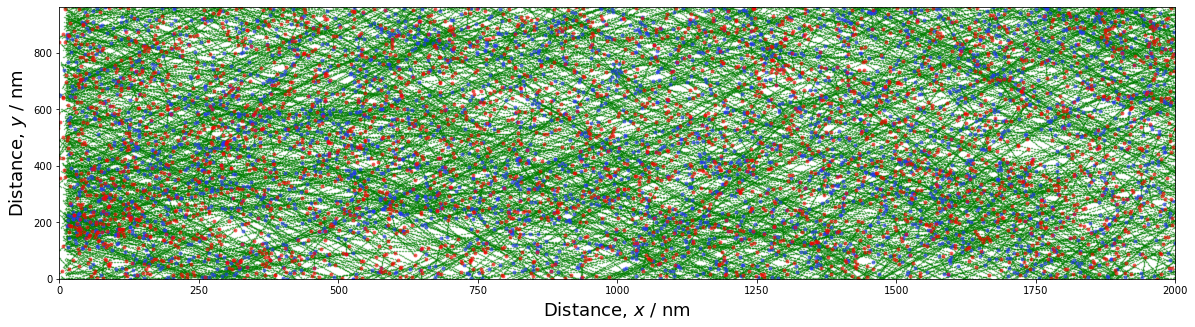

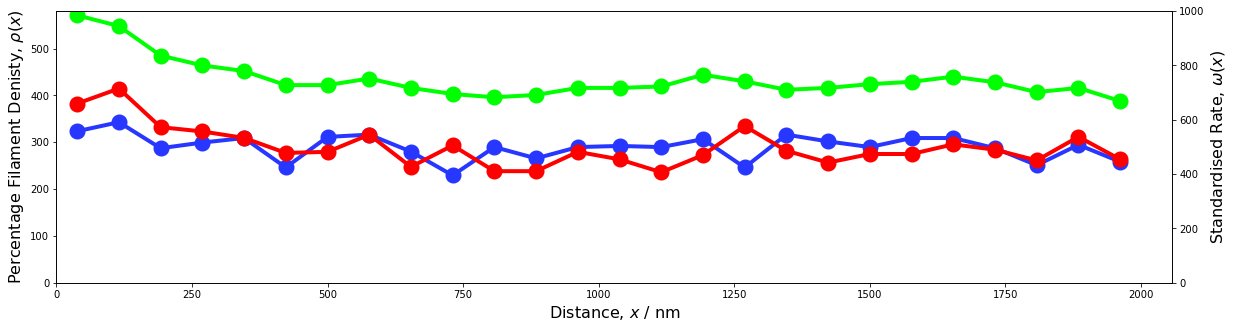

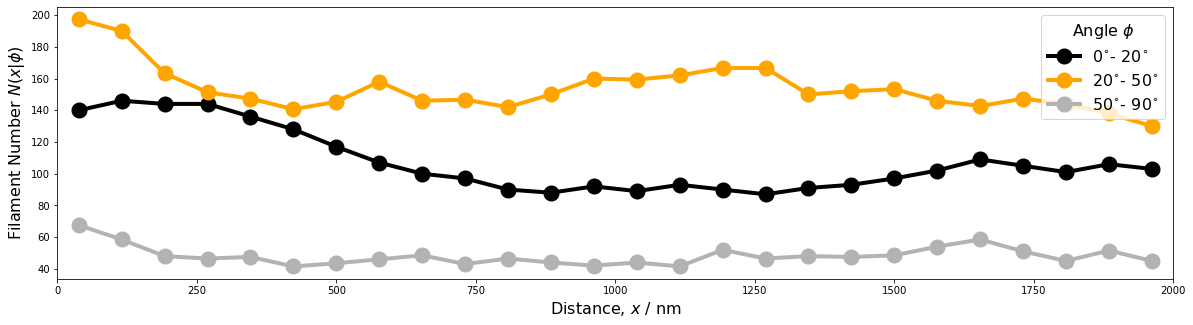

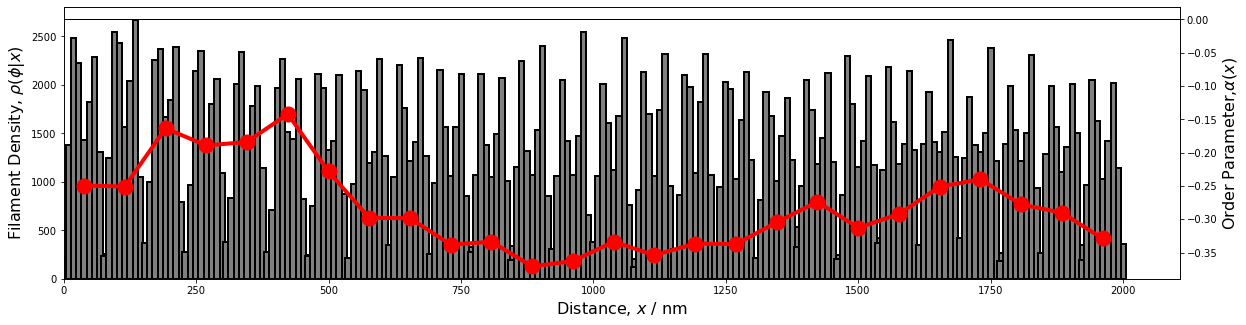

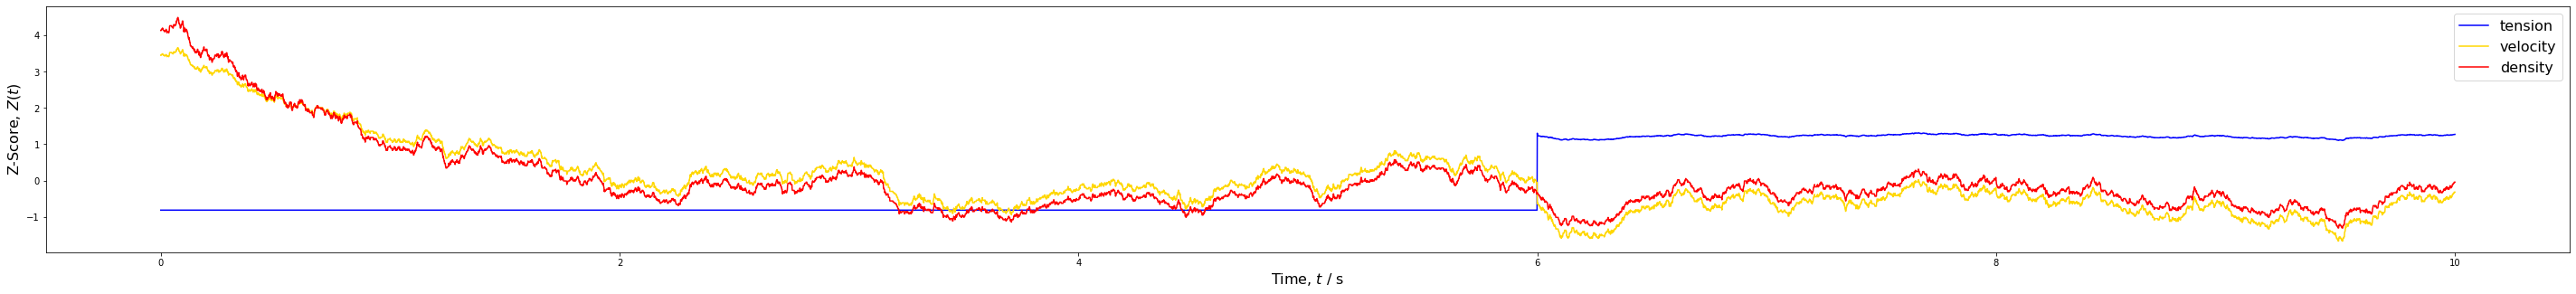

In [22]:
#### ------------------------------- Filament Plot ------------------------------ ###

# getting positions
xFil = n.getPositions( n.Monomers )
xBranch = n.getPositions( n.Branches )
xCap = n.getPositions( n.Caps )

figure(figsize=(20,5))

# plotting all monomers as different colour points 
plot(xFil.T[1],xFil.T[0],'g',marker=".",linewidth=0,ms=1,alpha=0.5)
plot(xBranch.T[1],xBranch.T[0],'#2737ff',marker=".",linewidth=0,ms=6,alpha=0.5)
plot(xCap.T[1],xCap.T[0],'#ff0000',marker=".",linewidth=0,ms=6,alpha=0.5)

# plotting options
xlabel(r"Distance, $x$ / nm",fontsize=18)
ylabel(r"Distance, $y$ / nm",fontsize=18)
ylim(0,n.xBoundary); xlim(0,2000);

# ------------------------------- calculate statistics ---------------------------------- #

filamentDensity,branchRate,capRate,filNumber,phiDist,orderParam = getStatistics(n,xEdges,phiEdges1,phiEdges2)

### ------------------------------- Density Plot ------------------------------ ###

f,ax1 = subplots()
ax2 = ax1.twinx()

f.set_figheight(5)
f.set_figwidth(20)

# plotting rates and density
ax1.plot( xCenters, filamentDensity, '#00ff00',mec='#00ff00',marker="o",mew="4",ms=12,linewidth=4)
ax2.plot( xCenters, branchRate, '#2737ff',mec='#2737ff',marker="o",mew="4",ms=12,linewidth=4)
ax2.plot( xCenters, capRate, '#ff0000',mec='#ff0000',marker="o",mew="4",ms=12,linewidth=4)

# plotting options
ax1.set_xlabel(r"Distance, $x$ / nm",fontsize=16)
ax1.set_ylabel(r"Percentage Filament Denisty, $\rho(x)$",fontsize=16)
ax2.set_ylabel(r"Standardised Rate, $\omega(x)$", fontsize=16)
ax1.set_ylim(0,); ax1.set_xlim(0,); ax2.set_ylim(0,1000)

### ------------------------------- Capping Ratios ------------------------------ ###

figure(figsize=(20,5))

# plot capping ratios
plot( xCenters, filNumber.T[0],'k',
     mec='k',marker="o",mew="4",ms=12,linewidth=4,
     label=r"0$^{\circ}$- 20$^{\circ}$")
plot( xCenters, 2.0/3.0*filNumber.T[1],'orange',
     mec='orange',marker="o",mew="4",ms=12,linewidth=4,
     label=r"20$^{\circ}$- 50$^{\circ}$")
plot( xCenters, 1.0/2.0*filNumber.T[2],'0.7',
     mec='0.7', marker="o",mew="4",ms=12,linewidth=4,
     label=r"50$^{\circ}$- 90$^{\circ}$")

# plotting options
xlabel(r"Distance, $x$ / nm",fontsize=16); l = legend(title=r"Angle $\phi$",fontsize=16)
ylabel(r"Filament Number $N(x\vert\phi)$",fontsize=16)
setp(l.get_title(),fontsize=16)
xlim(0,2000)

### ------------------------------- Angle Order ------------------------------ ###

f,ax1 = subplots()
ax2 = ax1.twinx()

f.set_figheight(5)
f.set_figwidth(20)

# plotting angle distributions
for x,y in zip([ linspace(x-40,x+40,len(phiCenters2)) for x in xCenters ],phiDist) :
    ax1.bar( x, y, width=10, color="gray", edgecolor="k", linewidth=2, align="center")

# and order parameter
ax2.plot( xCenters, orderParam, "r.-", marker="o", mec="r",mew="4",ms=12,linewidth=4, label="Order Parameter")
ax2.axhline( 0, color="k", linewidth=1);

# plotting options
ax1.set_ylabel(r"Filament Density, $\rho(\phi\vert x)$",fontsize=16);
ax2.set_ylabel(r"Order Parameter,$\alpha(x)$",fontsize=16);
ax1.set_xlabel(r"Distance, $x$ / nm",fontsize=16)
xlim(0,);

# ------------------- correlations -----------------------------------------------

figure(figsize=(50,5))
t = linspace(0,T,len(tension))
plot(t,zscore(tension),"blue",label="tension")
plot(t,zscore(velocity[1:]),"gold",label="velocity")
plot(t,zscore(density),"r",label="density")
legend(fontsize=16)
xlabel(r"Time, $t$ / s",fontsize=16);
ylabel(r"Z-Score, $Z(t)$",fontsize=16);

10001
222.46448406759137
0.3
213.56547061469993
204.6353333363509


(-4.0, 4.0)

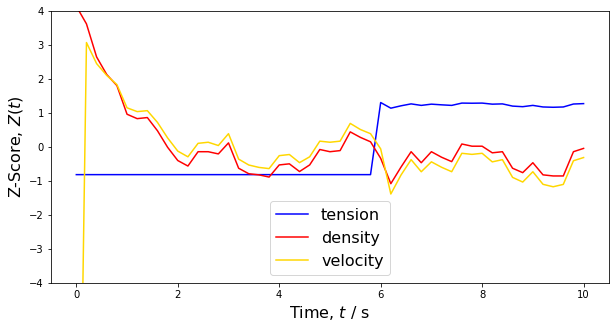

In [23]:
# ------------------- correlations -----------------------------------------------
print(len(tension))
#print(tension)
print
print(velocity[1000])
print
print(tension[3003])
print(velocity[3004])
print(velocity[10000])
k = 200

figure(figsize=(10,5))
t = linspace(0,T,len(tension))
plot(t[::k],zscore(tension)[::k],"blue",label="tension")
plot(t[::k],zscore(density)[::k],"r",label="density")
plot(t[::k],zscore(velocity)[::k],"gold",label="velocity")

legend(fontsize=16,loc='lower center')
xlabel(r"Time, $t$ / s",fontsize=16);
ylabel(r"Z-Score, $Z(t)$",fontsize=16);
ylim(-4,4)

In [ ]:
#print(velocity)

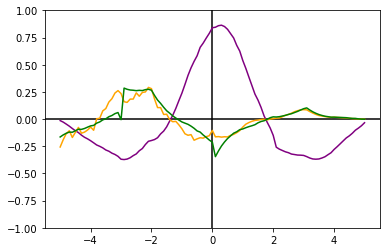

In [19]:
from scipy.signal import fftconvolve

def nCorr(x,y) :
    
    # remove means
    x -= nanmean(x)
    y -= nanmean(y)
    
    # return pearson correlation coefficient
    return fftconvolve(x[::-1],y,"full")/(normalg(x)*normalg(y))

axvline(0,color='black')
axhline(0,color='black')
K = nCorr(tension[::k],density[::k])
plot(linspace(-T/2,T/2,len(K)),K,'purple')

K = nCorr(density[::k],velocity[::k])
plot(linspace(-T/2,T/2,len(K)),K,'orange')

K = nCorr(tension[::k],velocity[::k])
plot(linspace(-T/2,T/2,len(K)),K,'green')
ylim(-1,1);

In [ ]:
#----------------------Save angles----------------------------#
#phiDistT = phiDist.transpose();
#savetxt("X-Angles.csv",
#array([
#(phiDistT)]).T,delimiter=",")

In [10]:
# getting previous positions and angles
thetas = n.getAngles(n.Frontier)
positions = n.getPositions(n.Frontier)

# passing samples to inital variables - TOGGLE ON/OFF When S.S is reached
xSteady = positions - array( len(positions)*[[0.0,n.xEdge]] )
dxSteady = array([ [dN*sin(theta),dN*cos(theta)] for theta in thetas ])

# initialising arrays to gather results
FD = []
BR = []
CR = []
AD = []
OP = []
PD = []
De = []
Ve = []
Te = []

# number of times to run the simulation
nRuns = 5

# looping over nRuns
for run in range(nRuns) :
    
    noise = array([normal(scale=0.001) for t in arange(0,T,dt) ])
    gaussian = array([ exp(-(t/sigma)**2)/sqrt(2*pi*sigma**2) for t in arange(-5.,5.,dt)])
    noise = convolve(noise,gaussian,mode="same")

    # velocity perturbation as heaviside function centered at tau
    def F(v,t) :
        if t > tau and t < (tau + dtau):
            ff = Fo + constant*visc*(v[int(t/dt)]-1) #Change to t-1 # Difference in force between time points
            return ff
        else:
            return Fo

    # ------------------------------- initialisation ---------------------------------- #

    # initial distribution of network
    try : # using previous positions and angles if possible
        
        
        xInit = xSteady
        dxInit = dxSteady
        
        # passing samples to inital variables
        #xSteady = positions - array( len(positions)*[[0.0,n.xEdge]] )
        #dxSteady = array([ [dN*sin(theta),dN*cos(theta)] for theta in thetas ])

    except : # otherwise initialise uniformly

        # sampling from uniform distribution given N
        print("Initializing uniformly")
        thetaDist = uniform(-pi,pi,size=N)
        xDist = uniform(low=0.0, high=filRange, size=N)
        yDist = uniform(low=0.0, high=dw/2.0, size=N)
        # passing samples to inital variables
        xInit = array([ [x,y] for x,y in zip(xDist,yDist) ])
        dxInit = array([ [dN*sin(theta),dN*cos(theta)] for theta in thetaDist ])

    # initialise network object
    n = network(rLambda, rBeta, rKappa,
                xSeed = xInit, dxSeed = dxInit,
                branchSigma = 15.0*pi/180.0,
                forceDirection = True, recordHistory = True)

    # ------------------------------- simulation ---------------------------------- #

    velocity = [0]; density = []; tension = []
    # while networks grows and up until time tFinal
    while n.nBarbed != 0 and n.tElapsed <= T :

        f = F(velocity,n.tElapsed)
        # evolve
        n.timeStep(dt, Fext = f)
        
        tension += [f] #Consider changing this to Fext
        velocity += [n.v]
        density += [n.D]
            
    print('loop1')
    ### ----------------------------- Processing Data --------------------------- ###

    filamentDensity,branchRate,capRate,filNumber,phiDist,orderParam = getStatistics(n,xEdges,phiEdges1,phiEdges2)

    FD += [filamentDensity]
    BR += [branchRate]
    CR += [capRate]
    AD += [filNumber]
    OP += [orderParam]
    PD += [phiDist]
    
    #if i % 100 == 0 and i > 100:
    #    n.plotData().savefig("figures/network"+str(j).zfill(3)+".png"); close();
    #    n.plotAngles().savefig("figures/angles"+str(j).zfill(3)+".png"); close();
    #    j+=1
    
    De += [density]
    Ve += [velocity[1:]]
    Te += [tension]
    print('loop')

loop1
loop
loop1
loop
loop1
loop
loop1
loop
loop1
loop


In [11]:
# Troubleshooting 
#print(n.tElapsed)

# Standard deviation of list 
# Using sum() + list comprehension 
mean_v = sum(velocity) / len(velocity) 
variance = sum([((x - mean_v) ** 2) for x in velocity]) / len(velocity) 
res = variance ** 0.5
#print(res)
print(mean_v)
#print(Te)
#print(xFil)
#print("xBranch:", xBranch)

207.7413891352208


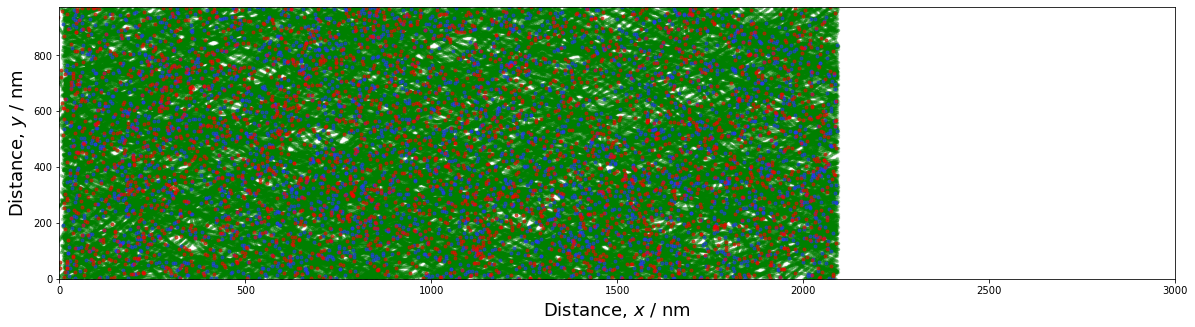

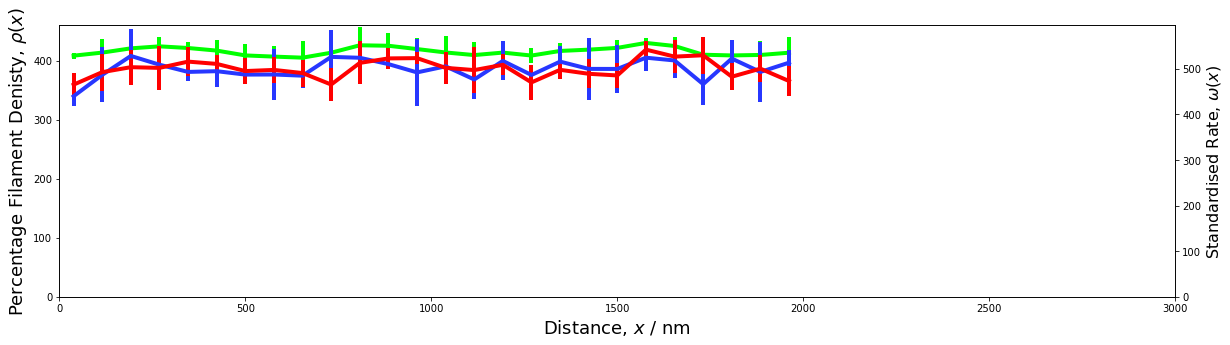

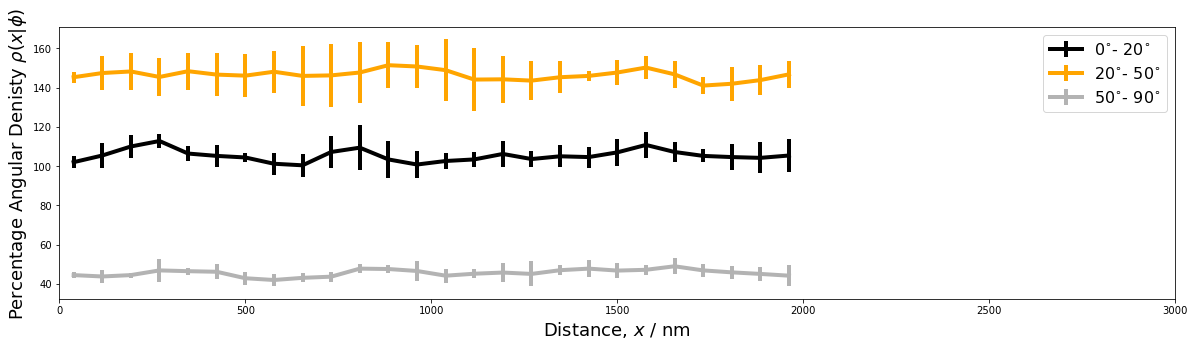

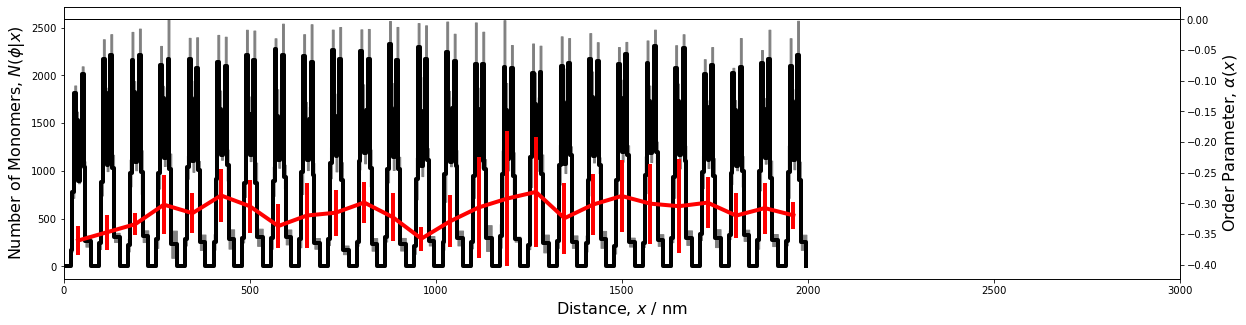

In [12]:
## ------------------------------- Filament Plot ------------------------------ ###


# getting positions
xFil = n.getPositions( n.Monomers )
xBranch = n.getPositions( n.Branches )
xCap = n.getPositions( n.Caps )

figure(figsize=(20,5))

# plotting all monomers as different colour points 
plot(xFil.T[1],xFil.T[0],'g',marker=".",linewidth=0,ms=5,alpha=0.2)
plot(xBranch.T[1],xBranch.T[0],'#2737ff',marker=".",linewidth=0,ms=6,alpha=0.5)
plot(xCap.T[1],xCap.T[0],'#ff0000',marker=".",linewidth=0,ms=6,alpha=0.5)

# plotting options
xlabel(r"Distance, $x$ / nm",fontsize=18)
ylabel(r"Distance, $y$ / nm",fontsize=18)
ylim(0,n.xBoundary); xlim(0,3000);

### ------------------------------- Density Plot ------------------------------ ###

f,ax1 = subplots()
ax2 = ax1.twinx()

f.set_figheight(5)
f.set_figwidth(20)

# plotting rates and density

ax1.errorbar( xCenters, mean(array(FD),axis=0),yerr=std(array(FD),axis=0), color='#00ff00',mec='#00ff00',marker="o",mew="4",ms=0,linewidth=4)
ax2.errorbar( xCenters, mean(array(BR),axis=0),yerr=std(array(BR),axis=0), color='#2737ff',mec='#2737ff',marker="o",mew="4",ms=0,linewidth=4)
ax2.errorbar( xCenters, mean(array(CR),axis=0),yerr=std(array(CR),axis=0), color='#ff0000',mec='#ff0000',marker="o",mew="4",ms=0,linewidth=4)

# plotting options
ax1.set_xlabel(r"Distance, $x$ / nm",fontsize=18)
ax1.set_ylabel(r"Percentage Filament Denisty, $\rho(x)$",fontsize=18)
ax2.set_ylabel(r"Standardised Rate, $\omega(x)$", fontsize=16)
ax1.set_ylim(0,); ax2.set_ylim(0,); ax1.set_xlim(0,3000);

f,ax = subplots()
f.set_figheight(5)
f.set_figwidth(20)

# plot capping ratios
ax.errorbar( xCenters, mean(array(AD),axis=0).T[0],yerr=std(array(AD),axis=0).T[0],color='k',
     mec='k',marker="o",mew="4",ms=0,linewidth=4,
     label=r"0$^{\circ}$- 20$^{\circ}$")
ax.errorbar( xCenters, 2.0/3.0*mean(array(AD),axis=0).T[1],yerr=2.0/3.0*std(array(AD),axis=0).T[1],color='orange',
     mec='orange',marker="o",mew="4",ms=0,linewidth=4,
     label=r"20$^{\circ}$- 50$^{\circ}$")
ax.errorbar( xCenters, 1.0/2.0*mean(array(AD),axis=0).T[2],yerr=1.0/2.0*std(array(AD),axis=0).T[2],color='0.7',
     mec='0.7', marker="o",mew="4",ms=0,linewidth=4,
     label=r"50$^{\circ}$- 90$^{\circ}$")

# plotting options
xlabel(r"Distance, $x$ / nm",fontsize=18); legend(fontsize=16)
ylabel(r"Percentage Angular Denisty $\rho(x\vert\phi)$",fontsize=18)
xlim(0,3000);

f,ax1 = subplots()
ax2 = ax1.twinx()

f.set_figheight(5)
f.set_figwidth(20)

# getting distribution 
x = array([ hstack([x-35,linspace(x-20,x+20,len(phiCenters2)),x+35]) for x in xCenters ]).flatten()
y = hstack([zeros((26,1)),nanmean(array(PD),axis=0),zeros((26,1))]).flatten()
yerr = hstack([zeros((26,1)),nanstd(array(PD),axis=0),zeros((26,1))]).flatten()

# plot distribution
ax1.plot( x, y, "k",drawstyle="steps-post",linewidth=4)
ax1.fill_between(x,y-yerr,y+yerr, color="grey",step="post")
    
# and order parameter
ax2.errorbar( xCenters, nanmean(array(OP),axis=0),yerr=nanstd(array(OP),axis=0), color="r", linewidth=4, label="Order Parameter")
ax2.axhline( 0, color="k", linewidth=1);

# plotting options
ax1.set_ylabel(r"Number of Monomers, $N(\phi\vert x)$",fontsize=16);
ax2.set_ylabel(r"Order Parameter, $\alpha(x)$",fontsize=16);
ax1.set_xlabel(r"Distance, $x$ / nm",fontsize=16)
xlim(0,3000);

In [ ]:
# ------------------- correlations -----------------------------------------------

figure(figsize=(20,5))

t = linspace(0,T,len(tension))

zTe = zscore(array(Te),axis=1)
errorbar( t, mean(zTe,axis=0),yerr=std(zTe,axis=0),
         color='blue',label="tension",linewidth=4,alpha=0.25)

zVe = zscore(array(Ve),axis=1)
errorbar( t, mean(zVe,axis=0),yerr=std(zVe,axis=0),
         color='gold',label="velocity",linewidth=4,alpha=0.25)

zDe = zscore(array(De),axis=1)
errorbar( t, mean(zDe,axis=0),yerr=std(zDe,axis=0),
         color='red',label="density",linewidth=4,alpha=0.25)

legend(fontsize=16)
xlabel(r"Time, $t$ / s",fontsize=16);
ylabel(r"Z-Score, $Z(t)$",fontsize=16);

In [ ]:
figure(figsize=(10,10))
axvline(0,color='black')
axhline(0,color='black')
K = array([ nCorr(x,y) for x,y in zip(Te,De) ])
x = linspace(-T/2,T/2,len(K.T)); y = mean(K,axis=0); error = std(K,axis=0)
plot(x,y,color='purple')
fill_between(x, y-error, y+error,color="purple",alpha=0.5)

K = array([ nCorr(x,y) for x,y in zip(De,Ve) ])
x = linspace(-T/2,T/2,len(K.T)); y = mean(K,axis=0); error = std(K,axis=0)
plot(x,y,color='orange')
fill_between(x, y-error, y+error,color="orange",alpha=0.5)

K = array([ nCorr(x,y) for x,y in zip(Te,Ve) ])
x = linspace(-T/2,T/2,len(K.T)); y = mean(K,axis=0); error = std(K,axis=0)
plot(x,y,color='green')
fill_between(x, y-error, y+error,color="green",alpha=0.5)
ylim(-1,1); xlim(-4,4)
xlabel(r"Time Lag, $\tau$",fontsize=16)
ylabel(r"Pearson Coefficient, $\rho(\tau)$",fontsize=16)

In [ ]:
#print(len(velocity))
time= np.arange(0, T, dt)
#print(len(time))
plot(time,velocity[2:])
xlabel("Time, s",fontsize=18)
ylabel("Velocity, nm/s",fontsize=18)
#t.shape

In [ ]:
# ---------------------------------------save everything!! ----------------------- #
savetxt("WT/X-FD-BR-CR-20x.csv",
array([xCenters,
mean(array(FD),axis=0),std(array(FD),axis=0),
mean(array(BR),axis=0),std(array(BR),axis=0),
mean(array(CR),axis=0),std(array(CR),axis=0) ]).T,delimiter=",")

savetxt("WT/X-AD-20x.csv",array([xCenters,
1.0/1.0*mean(array(AD),axis=0).T[0],1.0/1.0*std(array(AD),axis=0).T[0],
2.0/3.0*mean(array(AD),axis=0).T[1],2.0/3.0*std(array(AD),axis=0).T[1],
1.0/2.0*mean(array(AD),axis=0).T[2],1.0/2.0*std(array(AD),axis=0).T[2] ]).T,delimiter=",")

savetxt("WT/X-OP-20x.csv",array([xCenters,
mean(array(OP),axis=0),std(array(OP),axis=0) ]).T,delimiter=",")

savetxt("WT/X-TeDe-DeVe-TeVe-20x.csv",array([ linspace(-T/2,T/2,len(K.T)),
mean(array([ nCorr(x,y) for x,y in zip(Te,De) ]),axis=0),
 std(array([ nCorr(x,y) for x,y in zip(Te,De) ]),axis=0),
mean(array([ nCorr(x,y) for x,y in zip(De,Ve) ]),axis=0),
 std(array([ nCorr(x,y) for x,y in zip(De,Ve) ]),axis=0),
mean(array([ nCorr(x,y) for x,y in zip(Te,Ve) ]),axis=0),
 std(array([ nCorr(x,y) for x,y in zip(Te,Ve) ]),axis=0)]).T,delimiter=",")

k=200;

savetxt("WT/X-Te-De-Ve_20x_200k.csv", array([linspace(0,T,len(tension))[::k],
mean(array(Te),axis=0)[::k],std(array(Te),axis=0)[::k],
mean(array(De),axis=0)[::k],std(array(De),axis=0)[::k],
mean(array(Ve),axis=0)[::k],std(array(Ve),axis=0)[::k],]).T,delimiter=",")

In [ ]:
# function that calculates relevant statistics given a network object that has already been run
def getAngleSample(networkObject,xEdges2) :
    
    # getting positions
    xFil = networkObject.getPositions( networkObject.Monomers )

    # angular orientation of filaments
    phiFil = networkObject.getAngles ( networkObject.Monomers )

    # binning monomers into x-slices
    filMasks = [ ( x <= xFil.T[1] ) * ( xFil.T[1] <= y ) for x,y in zip(xEdges2[:-1],xEdges2[1:]) ]

    # and using these bins to calculate angule histograms at each slice
    phiDensity = [ list((phiFil[mask]*180/pi).astype(str)) for mask in filMasks ]
    
    # return relevant statistics
    return phiDensity

In [ ]:
with open("correlated-sampleAngles.csv","w") as outfile :

    output = "\n".join([ ",".join(x) for x in getAngleSample(n,xEdges) ])
    outfile.write(output)